# Spatial molecular imaging cell type classification challenge

## Background

**Spatial molecular imaging** (SMI) technologies allow us to simultaneously capture microscopy images of individual cells and profile the sub-cellular presence (or *expression*) of certain types molecules within those cells. Imaging large numbers of cells over a tissue region can then give insight into the structurally organisation of the tissue, interactions between different types of cells, and potential association with biological processes (which might lead to disease).

**Cell type** refers to the identity of cells. Historically, cell types have been designated through visual features (e.g. shape, size) and more recently through their molecular properties (e.g. genes or proteins expressed). SMI allows both types of information to be integrated to define cell type and - in some instances - is leading biologists to rethink the classifications of cells.

## The Challenge

This challenge is divided into two parts. In part one, we would like you to build a **cell type classifier**. The classifier will use SMI data input and report a cell type designation. We have provided you with a training data set with labelled data. In the second part, we would like you to examine the **validity of those cell type labels** and to investigate if there alternative annotations that might be consistent with the data.

You will work in small groups of 3-5 people. Each group will need to:

1. Plan a model development strategy (Part 1)
2. Develop a benchmarking strategy (Part 1)
3. Design an exploratory strategy (Part 2)

## Outputs

### Classification

Each group will submit an output file for Part 1 on **Monday at 12:00**. The output file (comma separated) should contain the following columns:

1. Field of View ID
2. Cell ID (within Field of View)
3. Your Predicted Label

The output file will be used by the organisers to score your predictions.

Each group will also deliver a short 15 minute presentation **Monday, 11:00-12:00** describing their efforts.

1. Can you describe the most important distinguishing features associated with each cell type?
2. Are there cell types harder to distinguish than others?


### Report

Each group will submit a joint written report (two pages A4 or notebook) describing their work by **16:00, 31 July 2023** to Health Data Research UK (phd@hdruk.ac.uk). Any groups or individuals that fail to contribute towards and submit a report will be ineligible to participate in the Roche Internship programme or any future Health Data Research UK training opportunities. 

### Internship Report

Individuals wishing to be considered for an internship should produce an *individual* written report of no more than 6 A4 pages (excluding figures, tables and references). You should use an 11pt Arial (or equivalent) font with page margins no smaller than 2cm. These should be submitted by **16:00, 31 August 2023** to Health Data Research UK (phd@hdruk.ac.uk).


# Exploring the data

Lets import some libraries that we will make use of:

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imageio import imread
from PIL import Image
from umap import UMAP
import random

## Data

The data is contained within two folders: `for_participants` and `images`. 

- `for_participants`:
    - `metadata.csv` : includes the `cell_ID`, `fov` (field of view)  and the `cell_type`. Some of the entries in the `cell_type` column are    missing. The main task of the hackathon is to predict the cell type of the missing entries
    - `Lung5_Rep1_exprMat_file.csv`: includes all the measures expressions per cell
    - `Lung5_Rep1_aggregated_image_features.csv`: includes a set of simple features which are calculated based on the images of the cells
    - `Lung5_Rep1_fov_positions_file.csv`: includes the global position of each of field of views 
 
- `images`: inlcudes the cell images. The names can be matched with the `cell_ID` and `fov` in the .csv files. 

*Important Note*: For the participants who do not have access to powerful computional resources, they can focus on only using these field of views: `[1, 2, 3, 6, 7, 8, 11, 12, 13, 16, 17, 18, 21, 22, 23, 26, 27, 28]`. (The FOVs are selected in such a way that they keep their spatial information)

In the following, we provide an overview of the data:

### Metadata

The metadata file (`for_participants/metadata.csv`) contains the labelled cell type information. Now, let's read in the file and see the first few entries:

In [2]:
metadata = pd.read_csv("for_participants/metadata.csv").iloc[:,1:]
metadata.head()

,fov,cell_ID,cell_type
0,1,1,Dendritic
1,1,2,Macrophage
2,1,3,Neuroendocrine
3,1,4,Macrophage
4,1,5,Macrophage


print("missing labels:", metadata.cell_type.isna().mean().round(2))The file consists of three columns:

1. `fov` meaning "field of view" (FOV) which describes the section of the overall image where the cell was location,
2. `cell_ID` is the identifier of a cell *within* the field of view,
3. `cell_type` which is given cell type label for that cell.

Some of the entries in the `cell_type` column are missing. The main task for Part 1 is to predict the cell type of the missing entries.


In [3]:
print("missing labels:", metadata.cell_type.isna().mean().round(2))

missing labels: 0.33


### Expression data

We shall now examine the matched gene expression data. Let's read in the file and display the first few lines:

In [4]:
Lung5_Rep1_exprMat_file = pd.read_csv("for_participants/Lung5_Rep1_exprMat_file.csv")
Lung5_Rep1_exprMat_file.head()

,fov,cell_ID,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,...,NegPrb14,NegPrb15,NegPrb16,NegPrb17,NegPrb18,NegPrb19,NegPrb20,NegPrb21,NegPrb22,NegPrb23
0,1,0,15,38,16,29,13,51,9,17,...,18,7,9,11,14,12,31,11,13,13
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,3,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Each row corresponds to an individual cell located in a specific field of view (`fov`) and whose identity within that FOV is given by `cell_ID`. While the columns (excluding the first two) show the level of expression of 960 genes. The last 20 columns are negative control probes (`NegPrb`) which measure the amount of background noise. These should ideally be zero but not always (think about what this means for analysing the expression of other probes).  Cells should match those of the metadata file. 

To visualise the data, we can use UMAP to project the data on to two dimensions:

In [5]:
cols = ~Lung5_Rep1_exprMat_file.columns.isin(["fov", "cell_ID"]) # identify the columns to exclude
X_emb = UMAP(n_components=2).fit_transform(Lung5_Rep1_exprMat_file.loc[:,cols]) # run UMAP

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Let's now display the UMAP projection:

Text(0, 0.5, 'UMAP2')

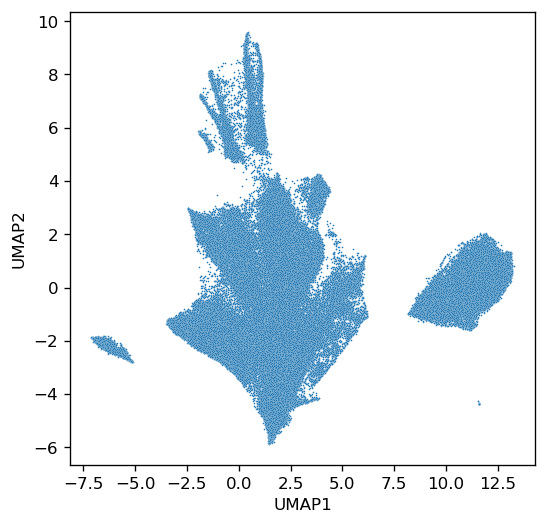

In [6]:
plt.rcParams['figure.dpi'] = 120 # set resolution of plots 
fig, ax = plt.subplots(figsize=(5,5))
ax = sns.scatterplot(x=X_emb[:,0],
                     y=X_emb[:,1],
                     s=1,
                     ax = ax)
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")

What do you think the different blobs mean in the UMAP?

### Images

We shall now examine a selection of cell images in the data set. The image files are contained in the folder `images` are there a large number of image files, one for each cell. Let's get the names of these JPEG files and display a random selection of 5 x 5 images:

In [9]:
image_files = glob.glob("for_participants/images/*.jpg")

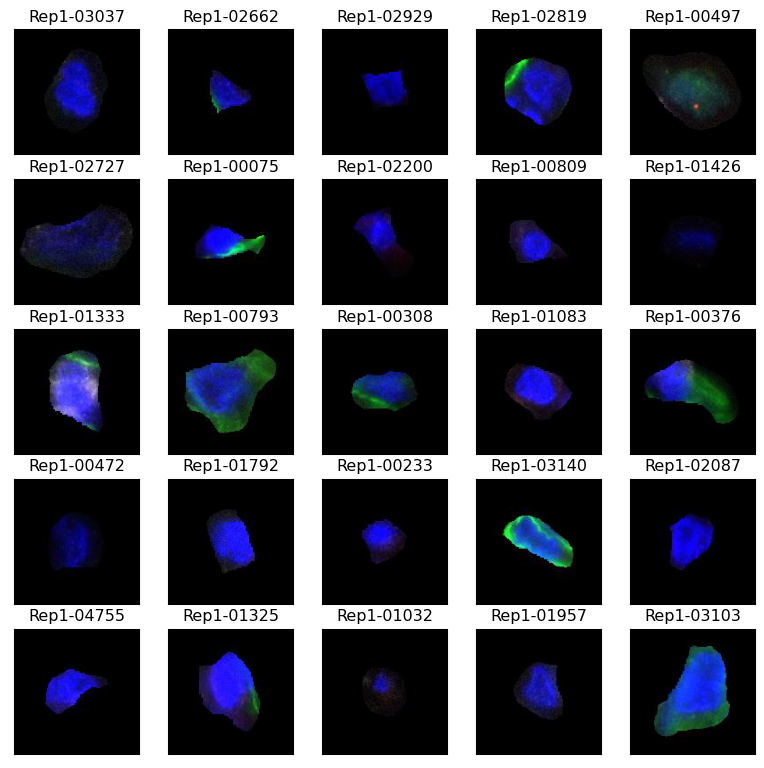

In [10]:
ncols = 5 # display ncols of images
nrows = 5 # display nrows of images

figsize = (2*ncols, 2*nrows)
plt.rcParams['figure.dpi'] = 96 # set resolution of plots 
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize) # configure array of subplots

for i in range(nrows):
    for j in range(ncols):
        random_sample = random.sample(image_files, 1)[0] # randomly pick an image
        image = imread(random_sample) # read the image file
        fov = random_sample.split("_")[2] # extract fov number from file name
        cell_ID = random_sample.split("_")[-1].replace(".jpg","") # extract cell id from file name
        ax[i,j].imshow(image) # show the image
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].set_title(fov + "-" + cell_ID) # create a title
        

Each cell has been pre-segmented and is stained with four colours:

| Colour | Description |
| ------ | ----------- |
| Green | PanCK (Pan Cytokeratin) which is used to identify tumour cells. | 
| Red | CD45 which is used to identify blood cells. |
| Grey | CD3 which is used to identify immune T cells. |
| Blue | DAPI which is used to identify DNA. |

The cell images could be used as part of your classification algorithm.

## Aggregated image features

The aggregated image feature file (`for_participants/Lung5_Rep1_aggregated_image_features.csv`) contains positional and summary image features for each cell. 

In [11]:
Lung5_Rep1_aggregated_image_features = pd.read_csv("for_participants/Lung5_Rep1_aggregated_image_features.csv")
Lung5_Rep1_aggregated_image_features.head()

,fov,cell_ID,Area,AspectRatio,CenterX_local_px,CenterY_local_px,CenterX_global_px,CenterY_global_px,Width,Height,Mean.MembraneStain,Max.MembraneStain,Mean.PanCK,Max.PanCK,Mean.CD45,Max.CD45,Mean.CD3,Max.CD3,Mean.DAPI,Max.DAPI
0,1,1,1259,1.34,1027,3631,4215.888889,158847.666667,47,35,3473,7354,715,5755,361,845,22,731,4979,26374
1,1,2,3723,1.45,2904,3618,6092.888889,158834.666667,87,60,3895,13832,18374,53158,260,1232,13,686,1110,13229
2,1,3,2010,1.62,4026,3627,7214.888889,158843.666667,68,42,2892,6048,3265,37522,378,908,19,654,10482,33824
3,1,4,3358,0.47,4230,3597,7418.888889,158813.666667,48,102,6189,16091,485,964,679,2322,5,582,6065,39512
4,1,5,1213,1.00,4258,3629,7446.888889,158845.666667,38,38,8138,19281,549,874,566,1242,17,674,3311,30136


The features are described in the table below:

| Column Name | Description |
|--------|-------------|
| Area   | Number of pixels assigned to a given cell. |
|Aspect Ratio | Width divided by height. |
| CenterX_global_px | See “CenterX_local_px” description. The global positions describes the relative position of this transcript within the large sample reference frame. |
| CenterY_global_px | Same as “CenterX_global_px” but for the vertical dimension |
| CenterX_local_px | The horizontal position of this transcipt within the FOV, measured in pixels. The pixel edge length is 180nm. Thus, to convert to microns multiply the pixel value by 0.18 um per pixel. |
| CenterY_local_px | Same as “CenterX_local_px” but for the vertical dimension. | 
| Width | Cell’s maximum length in x dimension (pixels) | 
| Height | Cell’s maximum length in y dimension (pixels) |
| Mean.MembraneStain | Mean fluorescence intensity within a given cell for the channel detecting the membrane stain. |
| Max.MembraneStain | Maximum fluorescence intensity within a given cell for the channel detecting the membrane stain. |
| Mean.PanCK | Mean fluorescence intensity within a given cell for the Green Channel. As the morphology markers are customizable this column will change to match the requested markers in each experiment.| 
| Max.PanCK | Maximum fluorescence intensity within a given cell for the Green Channel. As the morphology markers are customizable this column will change to match the requested markers in each experiment.| 
| Mean.CD45 | Mean fluorescence intensity within a given cell for the Yellow Channel. As the morphology markers are customizable this column will change to match the requested markers in each experiment.| 
| Max.CD45 | Maximum fluorescence intensity within a given cell for the Yellow Channel. As the morphology markers are customizable this column will change to match the requested markers in each experiment.| 
| Mean.CD3 | Mean fluorescence intensity within a given cell for the Red Channel. As the morphology markers are customizable this column will change to match the requested markers in each experiment.| 
| Max.CD3 | Maximum fluorescence intensity within a given cell for the Red Channel. As the morphology markers are customizable this column will change to match the requested markers in each experiment.| 
| Mean.DAPI | Mean fluorescence intensity within a given cell for the DAPI Channel.| 
| Max.DAPI | Maximum fluorescence intensity within a given cell for the DAPI Channel.| 

Using the `fov` and `cell_ID` you can relate the tables. For example:

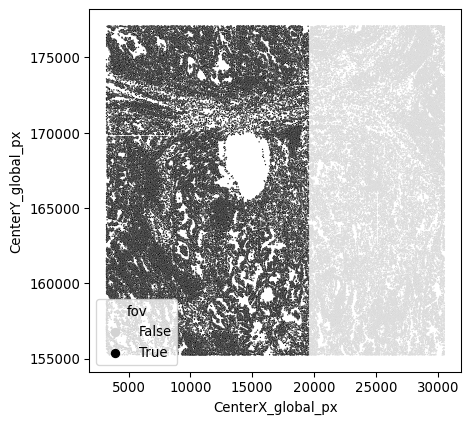

In [12]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5), sharex=True, sharey=True)

selected_fov = [1, 2, 3, 6, 7, 8, 11, 12, 13, 16, 17, 18, 21, 22, 23, 26, 27, 28]
row_index = Lung5_Rep1_aggregated_image_features.fov.isin(selected_fov)
ax = sns.scatterplot(data = Lung5_Rep1_aggregated_image_features,
                        x = "CenterX_global_px",
                        y = "CenterY_global_px",
                        hue = row_index,
                        palette = ["lightgray","black"],
                        s = 1,
                        ax = ax)

You may wish to investigate the properties of the image features with respect to cell type and position within the slide.

## FOV Positions File

The positions file is used to reference each FOV within the global structure of the sample.

In [13]:
Lung5_Rep1_fov_positions_file = pd.read_csv("for_participants/Lung5_Rep1_fov_positions_file.csv")
Lung5_Rep1_fov_positions_file.head()

,fov,x_global_px,y_global_px
0,1,3188.888889,155216.666667
1,2,8661.111111,155216.666667
2,3,14133.333333,155216.666667
3,4,19605.555556,155216.666667
4,5,25077.777778,155216.666667


The data file contains the following:

|Column Name    | Description | 
|------------|-------------| 
| fov | The Field Of View (FOV) number. |
| x_global_px | The relative x position of this the FOV, measured in pixels. To convert to microns multiply the pixel value by 0.18 um per pixel. All FOVs are the same dimension, 5472 x 3648 pixels. |
| y_global_px | See “x_global_px” description, but in for the vertical dimension. |

# A baseline classifier

As a start, we provide you with a baseline classification algorithm based on a *Random Forest*. This baseline, uses only the expression data and does not include the images nor the spatial information. 

We will first define the training data set:

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

X_train = Lung5_Rep1_exprMat_file.merge(metadata, on=["fov", "cell_ID"], how='inner')
col_index = ~X_train.columns.isin(["cell_ID", "fov", "cell_type"])
row_index = ~X_train.cell_type.isna()
y_train = X_train.loc[row_index, "cell_type"]
X_train = X_train.loc[row_index, col_index]

In [15]:
print(y_train)

0              Dendritic
1             Macrophage
2         Neuroendocrine
3             Macrophage
4             Macrophage
               ...      
100139    CD16+ Monocyte
100141     Myofibroblast
100144             CD4 T
100146        Macrophage
100147     Myofibroblast
Name: cell_type, Length: 67099, dtype: object


Next, we will define the classifier that we will use, in this case, the Random Forest algorithm:

In [16]:
clf = RandomForestClassifier(n_jobs=10)

Finally, we will use 5-fold cross validation to estimate the average performance.

In [17]:
cv_scores = cross_val_score(clf, X_train, y_train, n_jobs=4, cv=5)

/Users/cyau/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


In [20]:
print("Baseline accuracy across CV folds:",cv_scores)
print("Average baseline accuracy:", np.mean(cv_scores))

Baseline accuracy across CV folds: [0.67622951 0.67563338 0.66788376 0.68748137 0.67329905]
Average baseline accuracy: 0.6761054142928998


In your final submission, the score will be calculated on the real labels. However, the cross validation should provide a reasonable idea about the generalisation performance.

*Important Note*: The csv files can have different orders and they need to be matched based on `fov` and `cell_ID`.

## Things to consider

**Memory management:** There are 100,000 cells, how can you represent the data efficiently?

**Labelled data:** How do you make best use of the labelled data to improve test performance?

**Class distribution:** What is the balance of cell types?

**Class features:** What characterises the different cell types?

**Image size and shape:** The segmented cell images are of different shapes and sizes.

**Spatial colocalisation:** Do certain cell types exist in closer proximity than others?

